In [ ]:
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel2a")

using Gen
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN
using PyPlot

include("docker-parallel2a/NUTS.jl")
#include("docker-parallel2a/RJNUTS.jl")
include("docker-parallel2a/utils.jl")
include("docker-parallel2a/proposals.jl")
#include("docker-parallel2a/LoadData.jl")
include("hmc_mod.jl");

In [ ]:
Random.seed!(23) #Best so far: Seed 3 (see noise variance of 3.048)
data = load("boston.jld")["boston"]
data = data[shuffle(1:end), :]

# Generating test/training sets:
nrow, ncol = size(data)
nrow_test  = div(nrow, 2)
nrow_train = nrow - nrow_test

x = data[:,1:13]
y = data[:,14]

dx = fit(ZScoreTransform, x, dims=1)
StatsBase.transform!(dx, x)
dy = fit(ZScoreTransform, y, dims=1)
StatsBase.transform!(dy, y)

x_train = transpose(x[1:nrow_test,1:13])
x_test = transpose(x[nrow_test+1:nrow,1:13])
y_train = y[1:nrow_test]
y_test = y[nrow_test+1:nrow];

In [ ]:
#Network hyperparameters
k_real = 2 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1#0.1 #Input Weights, Biases Scale/Rate

#Bayesian Neural Network 

function G(x, trace)
    activation = tanh
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = @trace(gamma(α₁,β₁),:τ)
    #σ = 1/τ
    σ = 1
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    #σᵧ = 1/τᵧ
    σᵧ = 1
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σ for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σ for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    #Sy = Diagonal([100 for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
obs[:l] = 2

(best_trace,) = generate(interpolator,(x_train,),obs);
println(get_score(best_trace))

In [ ]:
#NUTS gradient check
α = 0.01
layers = 2
obs[:l] = layers
(trace,) = generate(interpolator,(x_train,),obs);
selection = select()
for i=1:layers+1 #Number of Layers
    push!(selection, (:W,i))
    push!(selection, (:b,i))
end

function grad_desc(trace)
    args = get_args(trace)
    retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
    argdiffs = map((_) -> NoChange(), args)
    (_, vals, gradient_trie) = choice_gradients(trace, selection, retval_grad)
    θ = to_array(vals, Float64)

    θtrace = from_array(vals, θ)
    (new_trace, _, _) = update(trace, args, argdiffs, θtrace)
    (_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
    gradient = to_array(gradient_trie, Float64)

    θnew = θ + α*gradient
    θnewtrace = from_array(vals, θnew)
    (new_trace, _, _) = update(new_trace, args, argdiffs, θnewtrace)
    return new_trace
end

traces = []
for i=1:1000
    trace = grad_desc(trace)
    push!(traces,trace)
    if i%10 == 0
        println(get_score(trace))
    end
end;
println("Finished")


In [ ]:
obs[:l] = layers
(best_trace,) = generate(interpolator,(x_train,),obs);
println(best_trace[:τ])

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    params = []
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        weight = trace[(:W,i)]
        for i in bias
            push!(params,i)
        end
        for i in weight
            push!(params,i)
        end
    end
    n = length(params)
    α = α₁ + (n/2)

    Σ = sum(params.^2)/2 
    β = 1/(1/β₁ + Σ)

    τ ~ gamma(α,β)
        
    obs_new[:τ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

new_trace = gibbs_hyperparameters(best_trace)
println(new_trace[:τ])
println(get_score(best_trace))
println(get_score(new_trace))

In [ ]:
while get_score(best_trace) < -380
    (best_trace,) = generate(interpolator,(x_train,),obs)
end
println(get_score(best_trace))

In [40]:
#FIXED EPSILON NUTS Attempt
include("NUTS3.jl")
include("hmc_mod.jl")
@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

M = 1
ϵ = 0.01
steps = 100
Δ_max = 1000

function within_move(trace)
    l = 4
    param_selection = select()
    
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    score1 = get_score(trace)
    #(new_trace, hmc_score) = hmc_mod(trace, param_selection, L=steps, eps=ϵ, check=false, observations=obs)
    new_trace = NUTS(trace,param_selection,ϵ,M,false)[M+1]
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    
    hmc_score = score2 - score1
    
    #if exp(hmc_score) == 1
        #accepted = 0.0
        #push!(within_acceptance, accepted)
        #return trace
    #else
        #accepted = 1.0
        #push!(within_acceptance, accepted)
        #return new_trace
    #end

    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = trace
        accepted = 0.0
        #println("Not Accepted")
    end
    push!(within_acceptance, accepted)

    return trace
end

traces = []
scores = []
across_acceptance = []
within_acceptance = []
trace = best_trace

iters = 5000
(best_trace,) = generate(interpolator,(x_train,),obs);
for i=1:iters
    #(trace, accepted) = layer_parameter(trace)
    #push!(across_acceptance, accepted)
    #trace  = gibbs_hyperparameters(trace)
    #trace  = gibbs_noise(trace)
    for i=1:1
        trace  = within_move(trace)
    end
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("Iter $i : $(get_score(trace))")
    if i%10 == 0
        #a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        #println("Chain $chain Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
    flush(stdout)
end

Iter 1 : -503.8014191962801
Iter 2 : -484.9923001385986
Iter 3 : -479.5076706845458
Iter 4 : -473.7422286691161
Iter 5 : -473.7422286691161
Iter 6 : -448.4461800856481
Iter 7 : -437.3232563737143
Iter 8 : -437.3232563737143
Iter 9 : -437.46607571102385
Iter 10 : -438.30773842890073
Epoch 10 W Acceptance Probability: 80.0 %
Iter 11 : -433.6932939705374
Iter 12 : -434.32607550574
Iter 13 : -419.0515592941254
Iter 14 : -419.0515592941254
Iter 15 : -417.371423025172
Iter 16 : -417.6029818863003
Iter 17 : -409.10127426055885
Iter 18 : -409.1945554576566
Iter 19 : -400.8233097510524
Iter 20 : -400.7698590879014
Epoch 20 W Acceptance Probability: 85.0 %
Iter 21 : -400.87881328385083
Iter 22 : -400.78328845721103
Iter 23 : -399.2218844235297
Iter 24 : -400.6991087869416
Iter 25 : -400.6991087869416
Iter 26 : -399.43401558469185
Iter 27 : -399.6337041398407
Iter 28 : -399.6337041398407
Iter 29 : -399.6337041398407
Iter 30 : -398.16426353351153
Epoch 30 W Acceptance Probability: 83.3333333333333

InterruptException: InterruptException:

In [ ]:
#NUTS WITH DUAL AVERAGING
#FIXED EPSILON NUTS Attempt
include("NUTS.jl")
(best_trace,) = generate(interpolator,(x_train,),obs);
@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m = 1
δ = 0.65
Δ_max = 100

function within_move(trace)
    l = 1
    param_selection = select()
    
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    score1 = get_score(trace)
    #(new_trace, hmc_score) = hmc_mod(trace, param_selection, L=l, eps=ϵ, check=false, observations=obs)
    #new_trace = NUTS(trace,param_selection,ϵ,M,false)[M+1]
    new_trace = NUTS(trace,param_selection,δ,2*m,m,false)[m+1]
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    
    hmc_score = score2 - score1
    
    if exp(hmc_score) == 1
        accepted = 0.0
        push!(within_acceptance, accepted)
        return trace
    else
        accepted = 1.0
        push!(within_acceptance, accepted)
        return new_trace
    end
end

traces = []
scores = []
across_acceptance = []
within_acceptance = []
trace = best_trace

iters = 5000

for i=1:iters
    #(trace, accepted) = layer_parameter(trace)
    #push!(across_acceptance, accepted)
    #trace  = gibbs_hyperparameters(trace)
    #trace  = gibbs_noise(trace)
    for i=1:1
        trace  = within_move(trace)
    end
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("Iter $i : $(get_score(trace))")
    if i%20 == 0
        #a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        #println("Chain $chain Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
    #println(trace[:y][1:4])
    flush(stdout)
end

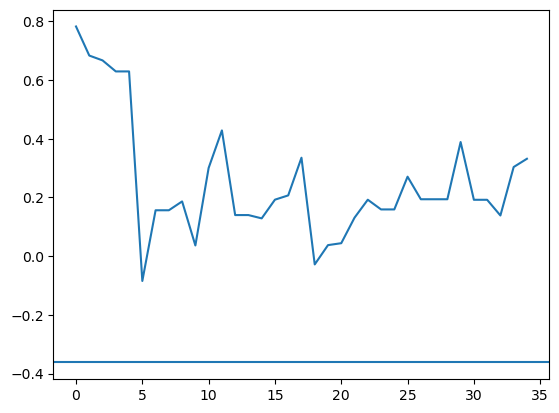

PyObject <matplotlib.lines.Line2D object at 0x7f88c54ddb90>

In [41]:
best_trace = traces[length(traces)];
plot([transpose(G(x_test,trace))[:,1][1] for trace in traces])
plt.axhline(y_test[1])
#println(best_trace[:l])
#println(best_trace[:τᵧ])
#plot([1/trace[:τ] for trace in traces])
#plot([1/trace[:τᵧ] for trace in traces])

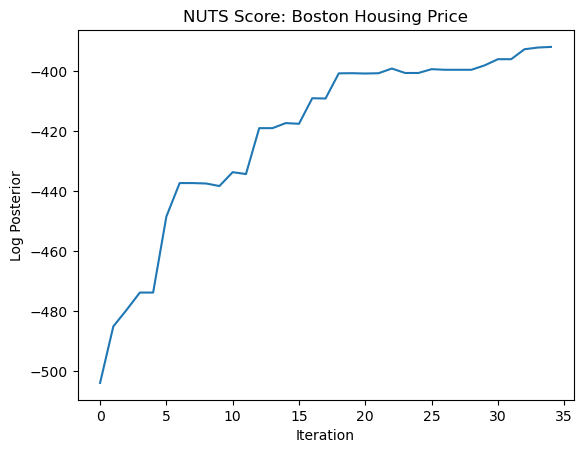

In [42]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

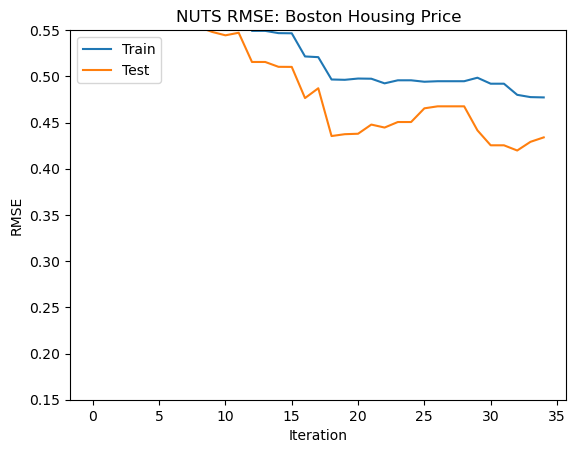

In [43]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylim(0.15,0.55)
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [ ]:
test_trace = traces[length(traces)-20]
pred_y = transpose(G(x_test,test_trace))[:,1]

In [ ]:
y_test

In [ ]:
y_pred2 = StatsBase.reconstruct(dy,pred_y)
y_real = StatsBase.reconstruct(dy,y_test)
√(sum((y_pred2 .- y_real).^2))/length(y_real)

In [ ]:
#----------------
#Marginalize RMSE
#----------------
j = 100
y_marginal = zeros(length(y_train))

count = 0

for i=j:length(traces)
    if i%10 == 0
        trace = traces[i]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += (pred_y)
        count += 1
    end
end

y_marginal = y_marginal ./ count

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 100
y_marginal = zeros(length(y_test))
count = 0

pred_ys = []
for i=j:length(traces)
    if i%10 == 0
        trace = traces[i]
        pred_y = transpose(G(x_test,trace))[:,1]
        push!(pred_ys,pred_y)
        y_marginal += (pred_y)
        count += 1
    end
end
y_marginal = y_marginal ./ count

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

In [ ]:
test_iter = 6
predictions = [preds[test_iter] for preds in pred_ys]
hist(predictions)
plt.axvline(mean(predictions),c="green",label="Mean of Predictions")
plt.axvline(y_test[test_iter],c="red",label="Observation")
plt.legend()